# Analyse der Layer-Anzahl für Multi-layered Perceptrons

In diesem Notebook analysieren wir die Leistung eines Multi-layered Perceptrons (MLP) basierend auf
verschiedenen Größen der Hidden-Layers. Wir erwarten, dass dieser Parameter einen erheblichen
Einfluss auf die Leistungsmetriken des Modell hat.

Als Basis verwenden wir das `sizes`-Array, welches die folgenden Größen annimmt:

$$\{ (1,1),~(1,10),~(1,20),~\ldots,~(1,50),~(10,1),~(10,10),~\ldots,~(10,50),~\ldots,~(50,50)\}$$

Wir kommen zum Schluss, dass die beste Präzision von 95,35% bei einer Größe von $(70,40)$ erreicht
wird. Der F1-Score liegt dabei bei 0,71.

**Hinweis**: Das Trainieren der Modelle hat ein ca. 20 Minuten gedauert. Daher wurden die Arrays mit
den Metriken gespeichert. Unten ist eine auskommentierte Zelle enthalten, um diese wieder
einzulesen. Somit müssen die Modelle nicht erneut trainiert werden.

## Feature-Matrix und Label laden

🔗 siehe [../generate.ipynb](../generate.ipynb)

In [1]:
max_file_count = None
none_replacement = 'all'

RANDOM_STATE = 42

In [2]:
import numpy as np
import os

feature_matrix = np.load(os.path.join(os.pardir,
                                      f'feature_{max_file_count or none_replacement}.npy'))

labels = np.load(os.path.join(os.pardir,
                              f'labels_{max_file_count or none_replacement}.npy'))

## Aufteilung in Trainings- und Testdaten

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels,
                                                    test_size=0.2, random_state=RANDOM_STATE)

In [4]:
print(X_train.shape)
print(X_test.shape)

(31697, 880)
(7925, 880)


In [5]:
LABEL_NO_WHISTLE = -1
LABEL_WHISTLE = 1

## Analyse der Layer

In [6]:
# get possible sizes from (1,1) to (50,50) with step length 10
sizes = []
for i in range(0, 100 + 10, 10):
    for j in range(0, 50 + 10, 10):
        sizes.append([max(1, i), max(1, j)])
sizes = np.array(sizes)

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from tqdm import tqdm

accuracies = []
precisions = []
recalls = []
f1s = []

for size in tqdm(sizes, unit='size'):
    model = MLPClassifier(hidden_layer_sizes=size, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    
    y_test_predict = model.predict(X_test)
    
    # proportion of correct predictions
    accuracies.append(metrics.accuracy_score(y_test, y_test_predict))
    
    # proportion of true positives under all positives
    precisions.append(metrics.precision_score(y_test, y_test_predict, zero_division=0))
    
    # proportion of true positives under actually positives
    recalls.append(metrics.recall_score(y_test, y_test_predict))
    
    # total performance
    f1s.append(metrics.f1_score(y_test, y_test_predict))

accuracies = np.array(accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)

np.save('accuracies.npy', accuracies)
np.save('precisions.npy', precisions)
np.save('recalls.npy', recalls)
np.save('f1s.npy', f1s)

100%|██████████| 66/66 [19:52<00:00, 18.07s/size]


In [8]:
# import numpy as np

# accuracies = np.load('accuracies.npy')
# precisions = np.load('precisions.npy')
# recalls = np.load('recalls.npy')
# f1s = np.load('f1s.npy')

In [9]:
size_best_f1 = sizes[np.argmax(f1s)]
size_best_recall = sizes[np.argmax(recalls)]
size_best_precision = sizes[np.argmax(precisions)]

print(f'best f1:        {np.max(f1s):.4f} with size {size_best_f1}')
print(f'best recall:    {np.max(recalls):.4f} with size {size_best_recall}')
print(f'best precision: {np.max(precisions):.4f} with size {size_best_precision}')

best f1:        0.8571 with size [90 10]
best recall:    0.9315 with size [70 50]
best precision: 0.9535 with size [70 40]


In [10]:
print(f'precision at best f1: {precisions[np.argmax(f1s)]:.2f}')
print(f'f1 at best precision: {f1s[np.argmax(precisions)]:.2f}')

precision at best f1: 0.85
f1 at best precision: 0.71


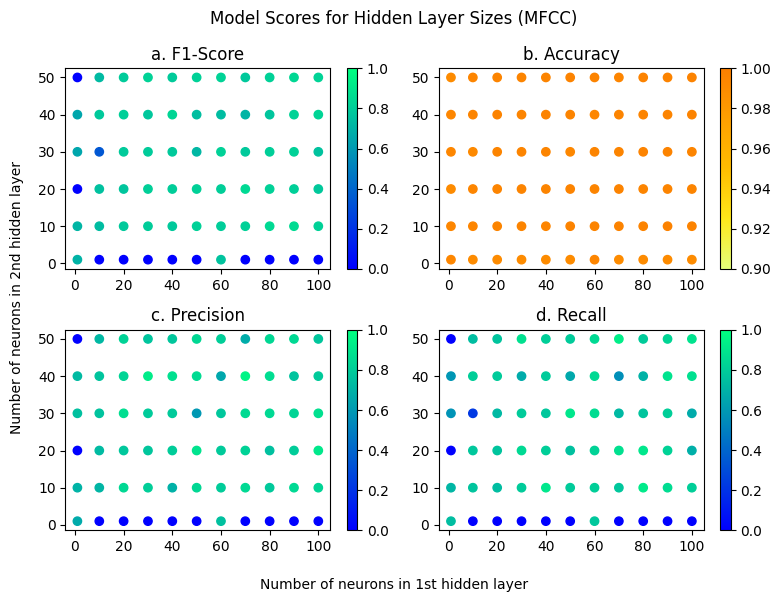

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import scipy.interpolate

fig, axs = plt.subplots(2, 2, figsize=(8,6))
cmap = 'winter'

norm = Normalize(vmin=0, vmax=1)

scatter_f1 = axs[0, 0].scatter(sizes[:, 0], sizes[:, 1], c=f1s, cmap=cmap, norm=norm)
fig.colorbar(scatter_f1, ax=axs[0, 0])
axs[0, 0].set_title('a. F1-Score')

scatter_accs = axs[0, 1].scatter(sizes[:, 0], sizes[:, 1], c=accuracies, cmap='Wistia',
                                 norm=Normalize(vmin=0.9, vmax=1))
fig.colorbar(scatter_accs, ax=axs[0, 1])
axs[0, 1].set_title('b. Accuracy')

scatter_precs = axs[1, 0].scatter(sizes[:, 0], sizes[:, 1], c=precisions, cmap=cmap, norm=norm)
fig.colorbar(scatter_precs, ax=axs[1, 0])
axs[1, 0].set_title('c. Precision')

scatter_recs = axs[1, 1].scatter(sizes[:, 0], sizes[:, 1], c=recalls, cmap=cmap, norm=norm)
fig.colorbar(scatter_recs, ax=axs[1, 1])
axs[1, 1].set_title('d. Recall')

fig.suptitle('Model Scores for Hidden Layer Sizes (MFCC)')
fig.supxlabel('Number of neurons in 1st hidden layer', fontsize=10)
fig.supylabel('Number of neurons in 2nd hidden layer', fontsize=10)

fig.tight_layout()

plt.savefig('plot.png')
plt.show()

## Resultierendes Modell mit bester Performance

In [12]:
import time

print(f'train model with size {size_best_precision}')

start_time = time.time()

# train model
model = MLPClassifier(hidden_layer_sizes=size_best_precision, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

print(f'Execution time: {time.time() - start_time:.2f}s')

train model with size [70 40]
Execution time: 10.34s


In [13]:
import skops.io as sio
sio.dump(model, f'mlp_layer.skops')

In [14]:
# generate predictions for test data
y_test_predict = model.predict(X_test)

In [15]:
print(f'#correct predictions: {y_test[y_test == y_test_predict].shape[0]}')
print(f'#false predictions:   {y_test[y_test != y_test_predict].shape[0]}')

#correct predictions: 7891
#false predictions:   34


In [16]:
print(f'#real whistles:      {y_test[y_test == LABEL_WHISTLE].shape[0]}')
print(f'#predicted whistles: {y_test_predict[y_test == LABEL_WHISTLE].shape[0]}')

#real whistles:      73
#predicted whistles: 73


In [17]:
print(f'#real no whistles:      {y_test[y_test == LABEL_NO_WHISTLE].shape[0]}')
print(f'#predicted no whistles: {y_test_predict[y_test == LABEL_NO_WHISTLE].shape[0]}')

#real no whistles:      7852
#predicted no whistles: 7852


In [18]:
# proportion of correct predictions
print(f'accuracy:  {metrics.accuracy_score(y_test, y_test_predict):.4f}')

# proportion of true positives under all positives
print(f'precision: {metrics.precision_score(y_test, y_test_predict):.4f}')

# proportion of true positives under actually positives
print(f'recall:    {metrics.recall_score(y_test, y_test_predict):.4f}')

# total performance
print(f'f1:        {metrics.f1_score(y_test, y_test_predict):.4f}')

accuracy:  0.9957
precision: 0.9535
recall:    0.5616
f1:        0.7069


In [19]:
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      7852
           1       0.95      0.56      0.71        73

    accuracy                           1.00      7925
   macro avg       0.97      0.78      0.85      7925
weighted avg       1.00      1.00      1.00      7925



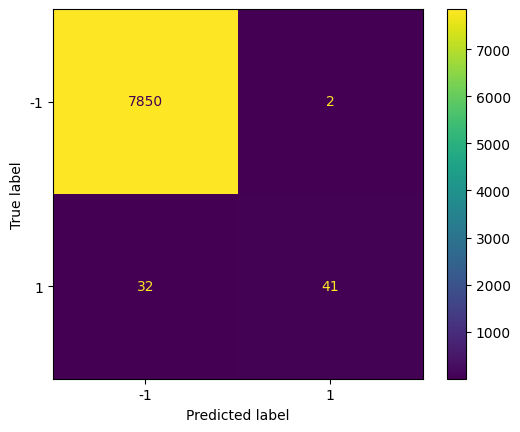

In [20]:
_ = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict)

In [21]:
# relative confusion matrix
print(metrics.confusion_matrix(y_test, y_test_predict) / y_test.shape[0])

[[9.90536278e-01 2.52365931e-04]
 [4.03785489e-03 5.17350158e-03]]
